In [24]:
import sys
# sys.path.append('../../')

from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
# from hnlpy.timeop import makefiltersos
# from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
from numpy.polynomial.polynomial import polyfit, polyval

import networkx as nx

# load fif file
import mne
mne_object=mne.io.read_raw_fif('../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif')


Opening raw data file ../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif...
Isotrak not found
    Range : 0 ... 2000 =      0.000 ...     1.000 secs
Ready.


C:\Users\zhouz\AppData\Local\Temp\ipykernel_26092\3952934649.py:25: RuntimeWarning: This filename (../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_object=mne.io.read_raw_fif('../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif')


In [2]:
# (Color Scheme) 
red         = [1, 0, 0]
pink        = [1, 0.65, 0.75]
black       = [0, 0, 0]
white       = [1, 1, 1]
blue        = [0, 0, 1]
mediumblue  = [0, 0.4, 0.7]
green       = [0, 1, 0]
darkgreen   = [0, 0.5, 0]
grey        = [0.5, 0.5, 0.5]
yellow      = [1, 1, 0]
deepyellow  = [1, 0.8, 0.2]
gold        = [212/255, 175/255, 55/255]
brown       = [150/255, 75/255, 0]
magenta     = [1, 0, 1] 
cyan        = [0, 1, 1]  
purple      = [0.6, 0.1, 0.9]

# % https://www.mathworks.com/help/matlab/creating_plots/specify-plot-colors.html
matlab_blue     = [0, 0.4470, 0.7410]
matlab_orange   = [0.8500, 0.3250, 0.0980]
matlab_gold     = [0.9290, 0.6940, 0.1250]
matlab_purple   = [0.4940, 0.1840, 0.5560]
matlab_green    = [0.4660, 0.6740, 0.1880]
matlab_cyan     = [0.3010, 0.7450, 0.9330]
matlab_red      = [0.6350, 0.0780, 0.1840]

# combine colors
condicolors = [darkgreen, red, blue, magenta, purple, purple]
dire3colors = [darkgreen, brown, magenta]
syn2colors = [darkgreen, pink]
HNLcolors = [darkgreen, deepyellow, pink]
freq7colors = [black, red, deepyellow, darkgreen, matlab_blue, blue, matlab_purple]

color_4st=['green','red','blue','black']

In [3]:
# load chan locs for topoplots
dict_loc=loadmat('../Archived/Pcorr_4states_2sestype/chan_locs/xyzlabels.mat')
x=dict_loc['x']
y=dict_loc['y']
z=dict_loc['z']
labels=dict_loc['labels']

# adjust coords for nilearn plots
coords=np.zeros((32,3))
for i in range(32):
    coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

#  construct text for networkx labels
labeldict = {}
for i in range(32):
    labeldict[i]=labels[i]

# load pos for networkx plots
pos_mat=loadmat('../Archived/Pcorr_4states_2sestype/chan_locs/pos.mat')
pos=pos_mat['pos']


# construct full edges_list
edges_list=list() # each edge is a two element tuple
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            edges_list.append((i,j))

In [4]:
# variable names for plotting
states4names=['Independent','Leading','Following','Mutual']
syn2names=['Synch','Synco']
states3names=['Independent','Unidirectional','Bidirectional']
band_labels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']

In [5]:
indices=loadmat('Indicies.mat')

# condi4_ind          = outdict['condi4_ind']
# syn_ind             = outdict['syn_ind']
syn2_condi4_ind     = indices['syn2_condi4_ind']
indices.keys()

dict_keys(['L_lead_ind', 'L_lead_synch_ind', 'L_lead_synco_ind', 'Mutual_ind', 'Mutual_synch_ind', 'Mutual_synco_ind', 'R_lead_ind', 'R_lead_synch_ind', 'R_lead_synco_ind', 'Uncoupled_ind', 'Uncoupled_synch_ind', 'Uncoupled_synco_ind', 'condi4_ind', 'syn2_condi4_ind', 'syn_ind', 'synch_condi4_ind', 'synch_ind', 'synco_condi4_ind', 'synco_ind'])

In [6]:
corrdict=loadmat('Corr_eeg144.mat')

eeg_empirical_correlation144x2  = corrdict['eeg_empirical_correlation144x2']     
eeg_partial_correlation144x2    = corrdict['eeg_partial_correlation144x2']       
intervals144                    = corrdict['intervals144']                       
samples144                      = corrdict['samples144']                         
session144                      = corrdict['session144']                         

In [7]:
#organize the adjacency matrices from partial correlation
eeg_partial_correlation144x2 = eeg_partial_correlation144x2.astype(bool)
A_follow_synco = np.zeros((36,7,32,32))
A_lead_synco = np.zeros((36,7,32,32))
A_ind_synco = np.zeros((36,7,32,32))
A_mutual_synco = np.zeros((36,7,32,32))
A_follow_synch = np.zeros((36,7,32,32))
A_lead_synch = np.zeros((36,7,32,32))
A_ind_synch = np.zeros((36,7,32,32))
A_mutual_synch = np.zeros((36,7,32,32))

A_follow_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synco_ind'],0,:,:,:]
A_follow_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],1,:,:,:]
A_lead_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],0,:,:,:]
A_lead_synco[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synco_ind'],1,:,:,:]
A_mutual_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],0,:,:,:] 
A_mutual_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],1,:,:,:]
A_ind_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],0,:,:,:]
A_ind_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],1,:,:,:]

A_follow_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synch_ind'],0,:,:,:]
A_follow_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],1,:,:,:]
A_lead_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],0,:,:,:]
A_lead_synch[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synch_ind'],1,:,:,:]
A_mutual_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],0,:,:,:] 
A_mutual_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],1,:,:,:]
A_ind_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],0,:,:,:]
A_ind_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],1,:,:,:]



In [8]:
# organized into np
A_synch=[A_ind_synch, A_lead_synch, A_follow_synch, A_mutual_synch]
A_synco=[A_ind_synco, A_lead_synco, A_follow_synco, A_mutual_synco]
A_syn=[A_synch, A_synco]


In [9]:
# compute degree centrality for all freq
syn_c=np.zeros((2,4,7,36,32))
for syn in range(2):
    for st in range(4):
        for freq in range(7):
            for tr in range(36):
                G = nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
                x = nx.betweenness_centrality(G)
                for chan in range(32):
                    syn_c[syn,st,freq,tr,chan]=x[chan]


In [10]:
# collect the z-scores 
zscore_betweenness_centrality_syn=np.zeros((2,4,36,7,32))
for syn in range(2):
    for st in range(4):
        for tr in range(36):
            for freq in range(7):
                G=nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
                nEdges = len(G.edges())
                del(G)

                c_random=np.zeros((1000,32))
                for sim in range(1000):
                    R=nx.gnm_random_graph(32, nEdges, seed=None, directed=False)
                    ctr=nx.betweenness_centrality(R)
                    del(R)
                    for chan in range(32):
                        c_random[sim,chan]=ctr[chan]
                    
                
                for chan in range(32):
                    ctr_ram=c_random[:,chan].tolist()
                    ctr_real=syn_c[syn,st,freq,tr,chan]
                    ctr_ram=[ctr_real]+ctr_ram
                    zscores= stats.zscore(ctr_ram)
                    zscore_betweenness_centrality_syn[syn,st,tr,freq,chan]=zscores[0]

# 137 min        


In [11]:
outdict = dict()
outdict['zscore_betweenness_centrality_syn']       = zscore_betweenness_centrality_syn
savemat('zscore_betweenness_centrality_syn',outdict,store_python_metadata = True) 

In [12]:
outdict=loadmat('zscore_betweenness_centrality_syn.mat')
zscore_degree_centrality_syn  = outdict['zscore_betweenness_centrality_syn']

In [13]:
# average the zscores
zscore_average_syn=np.zeros((2,4,7,32))
for syn in range(2):
    for st in range(4):
            for freq in range(7):
                for chan in range(32):
                    zscore_average_syn[syn,st,freq,chan]=np.mean(zscore_degree_centrality_syn[syn,st,:,freq,chan],axis=0)

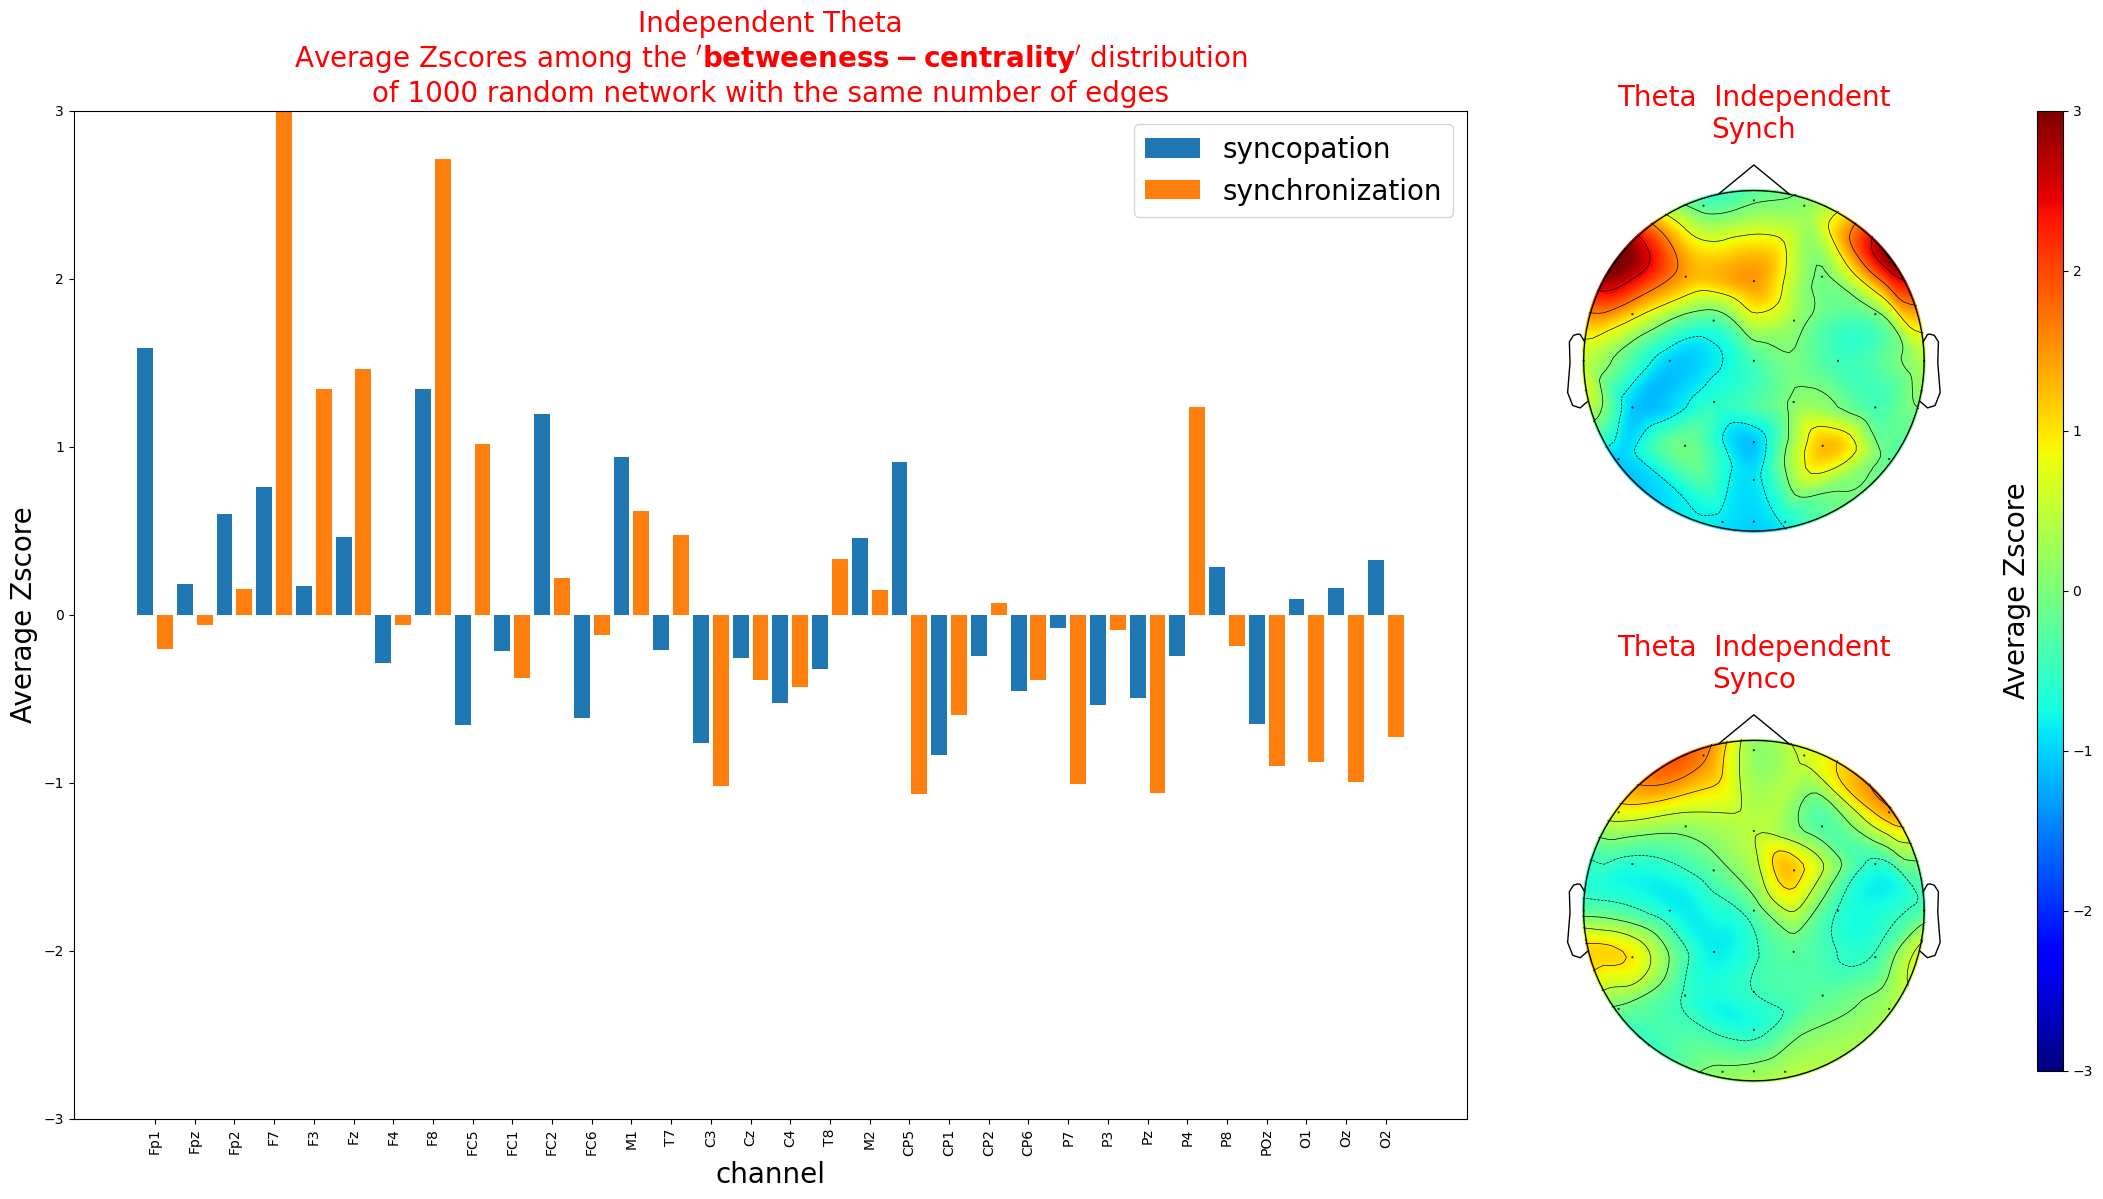

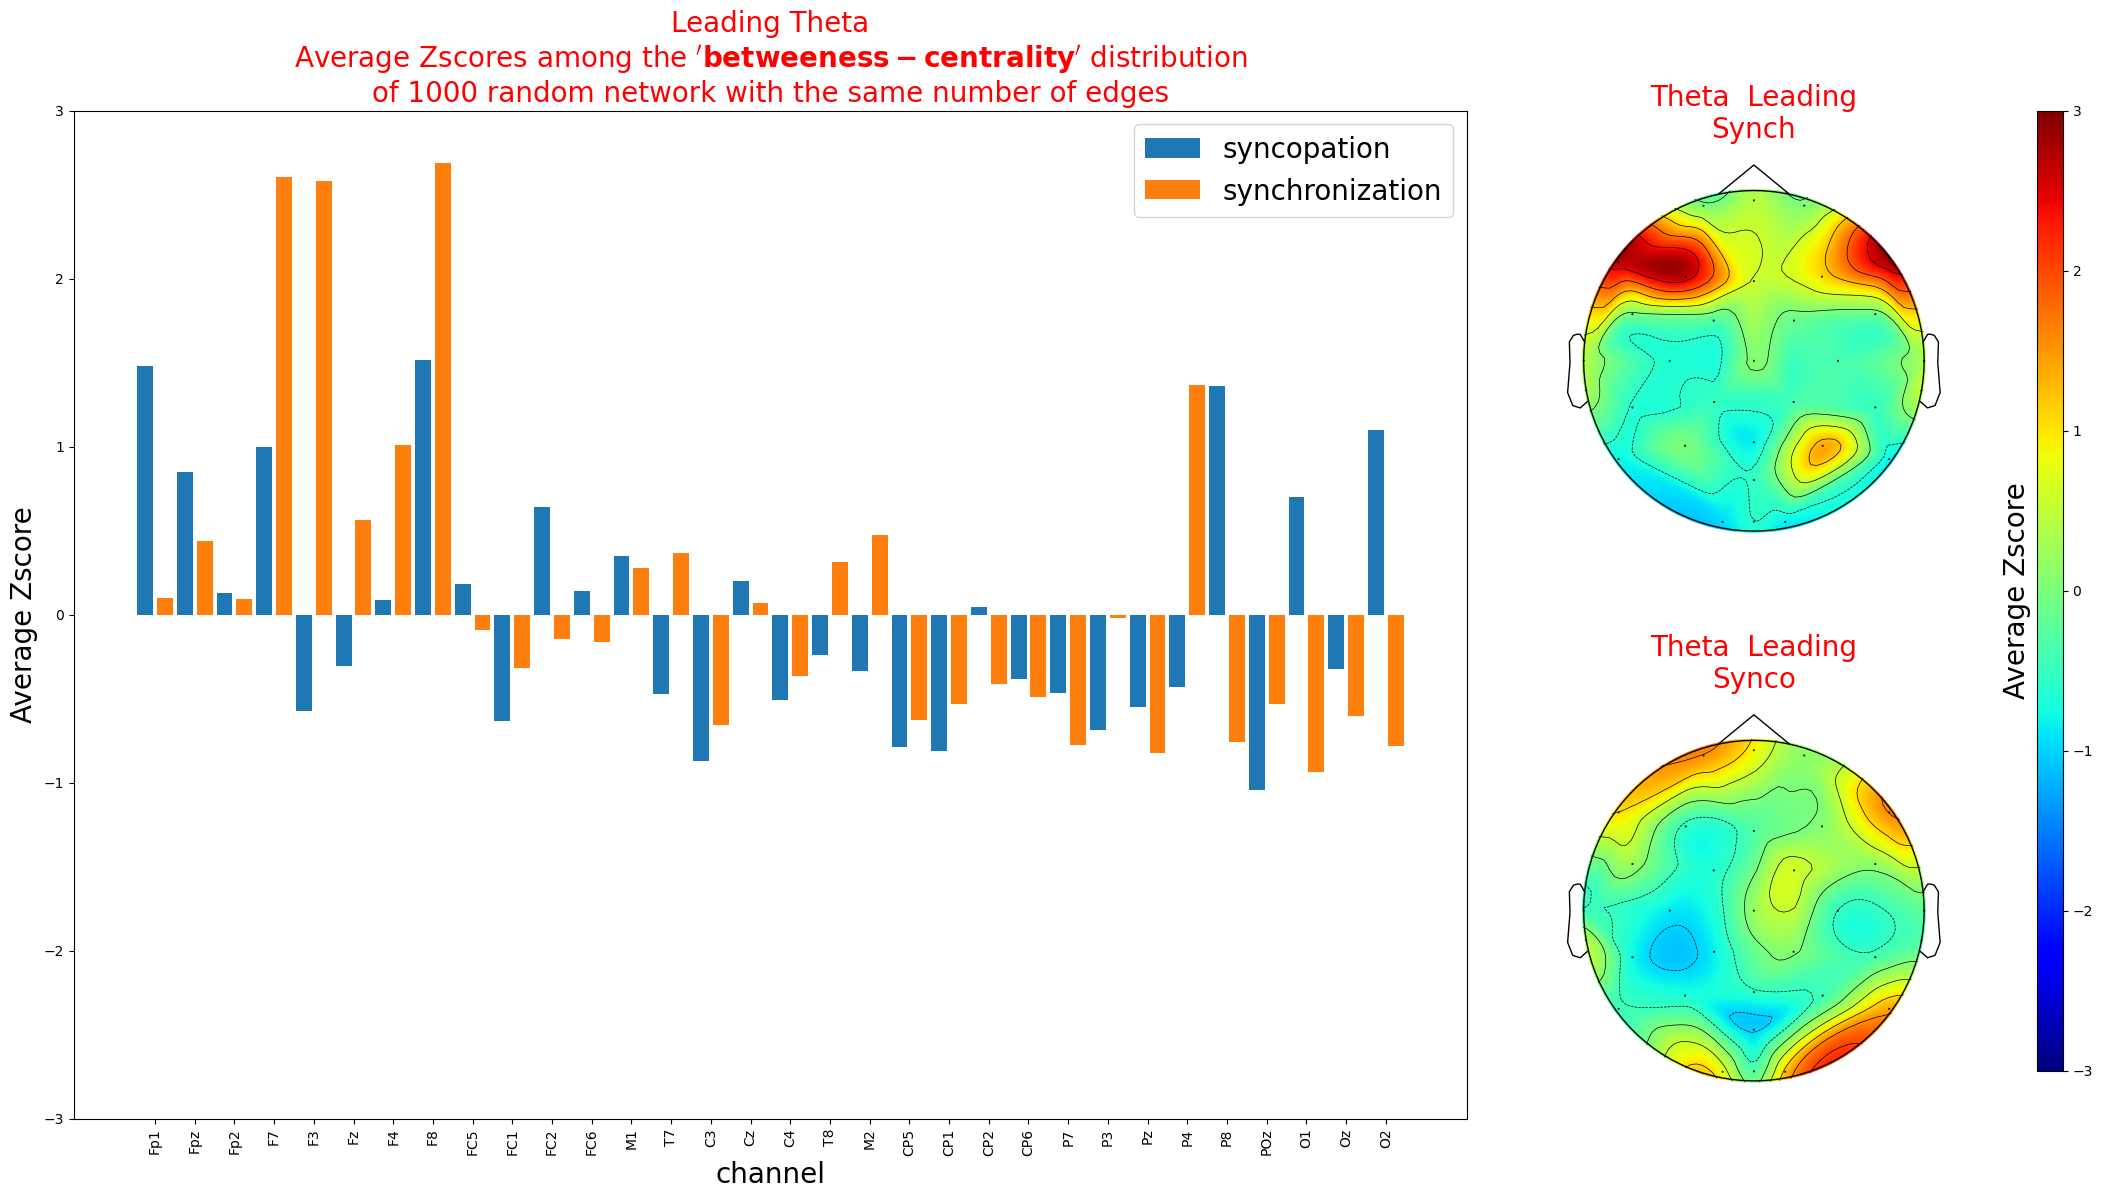

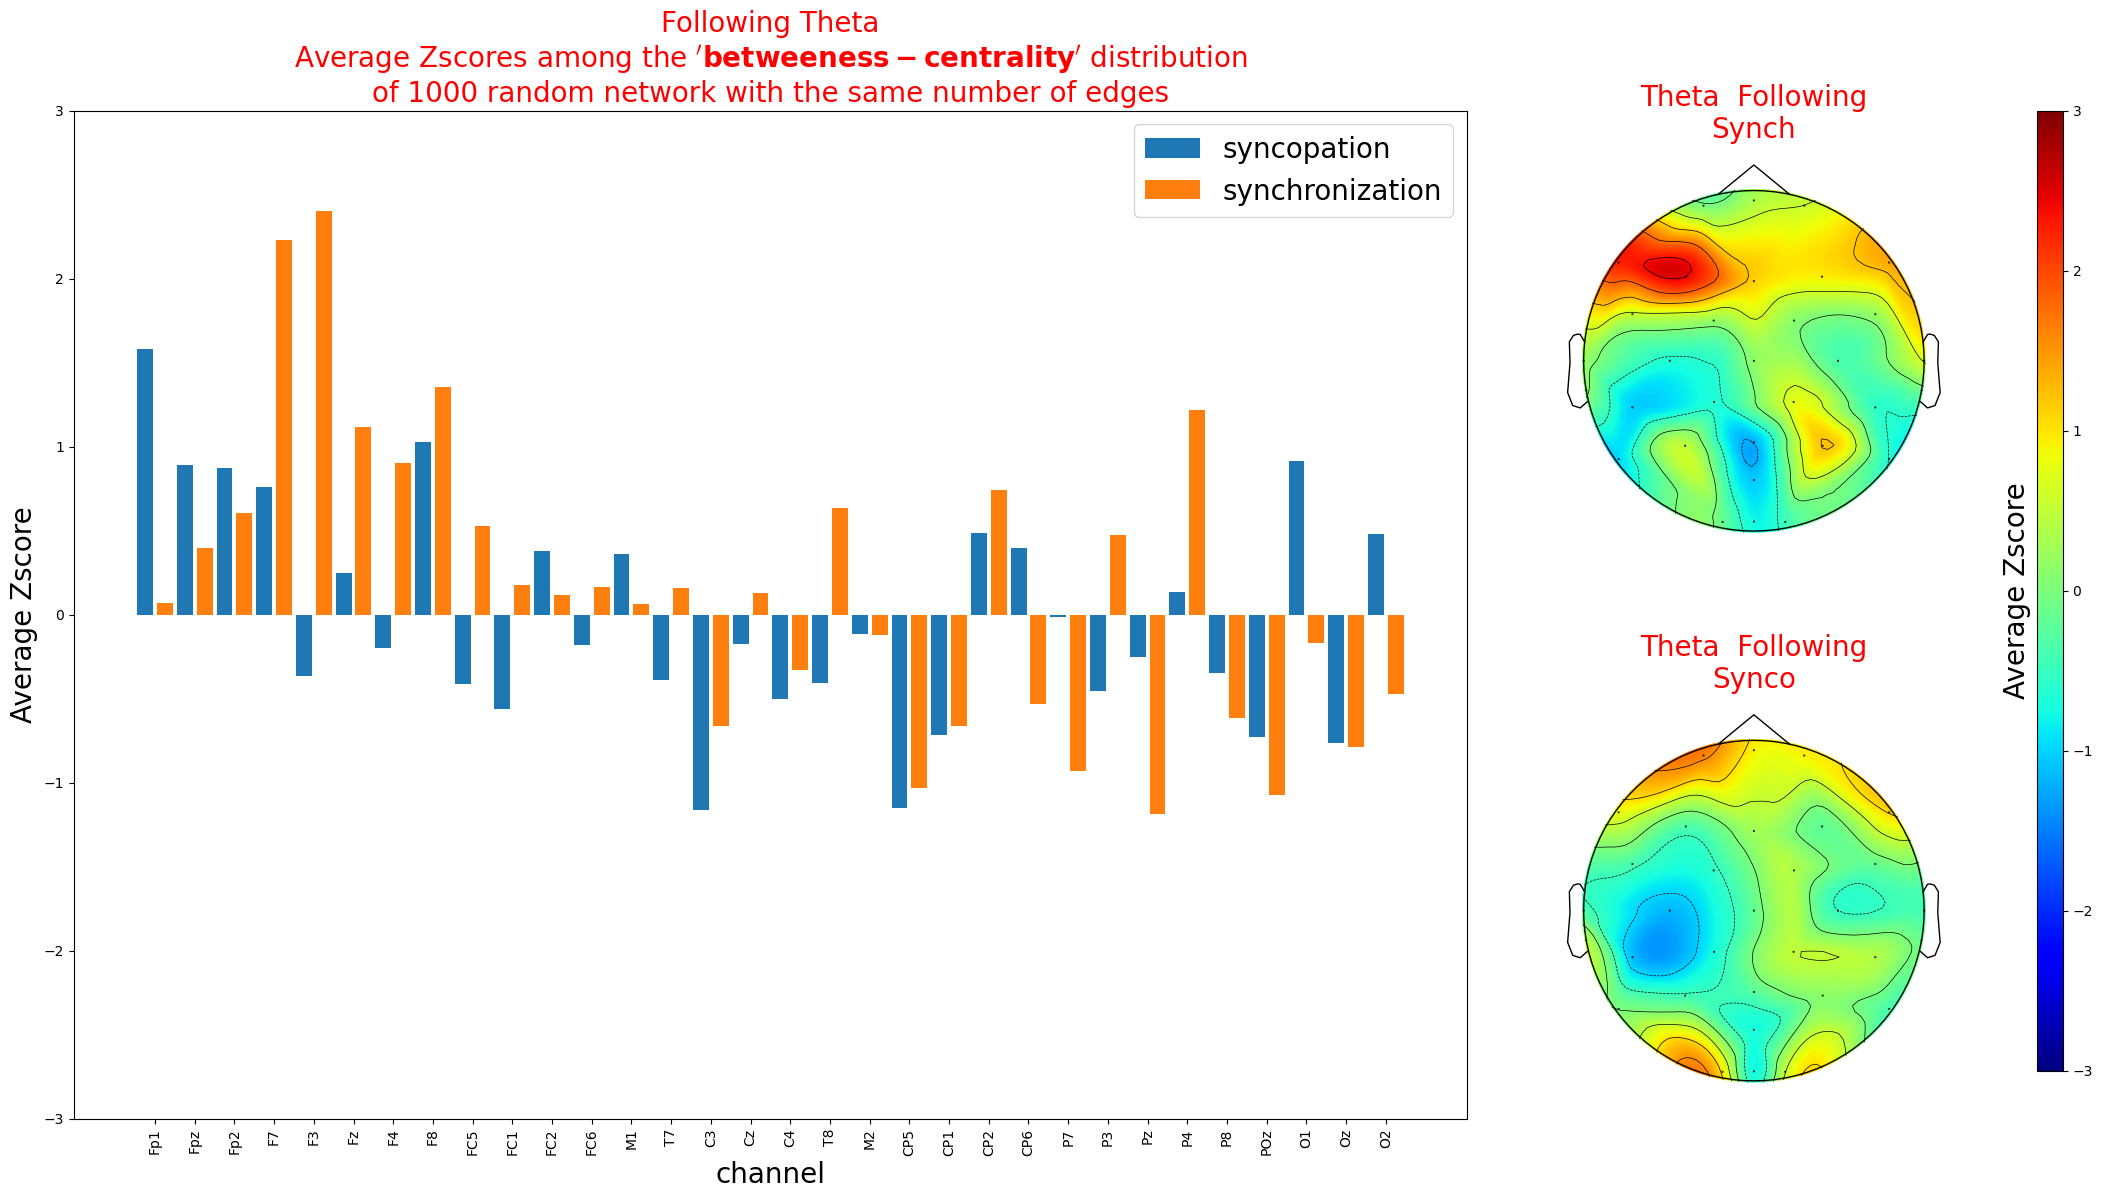

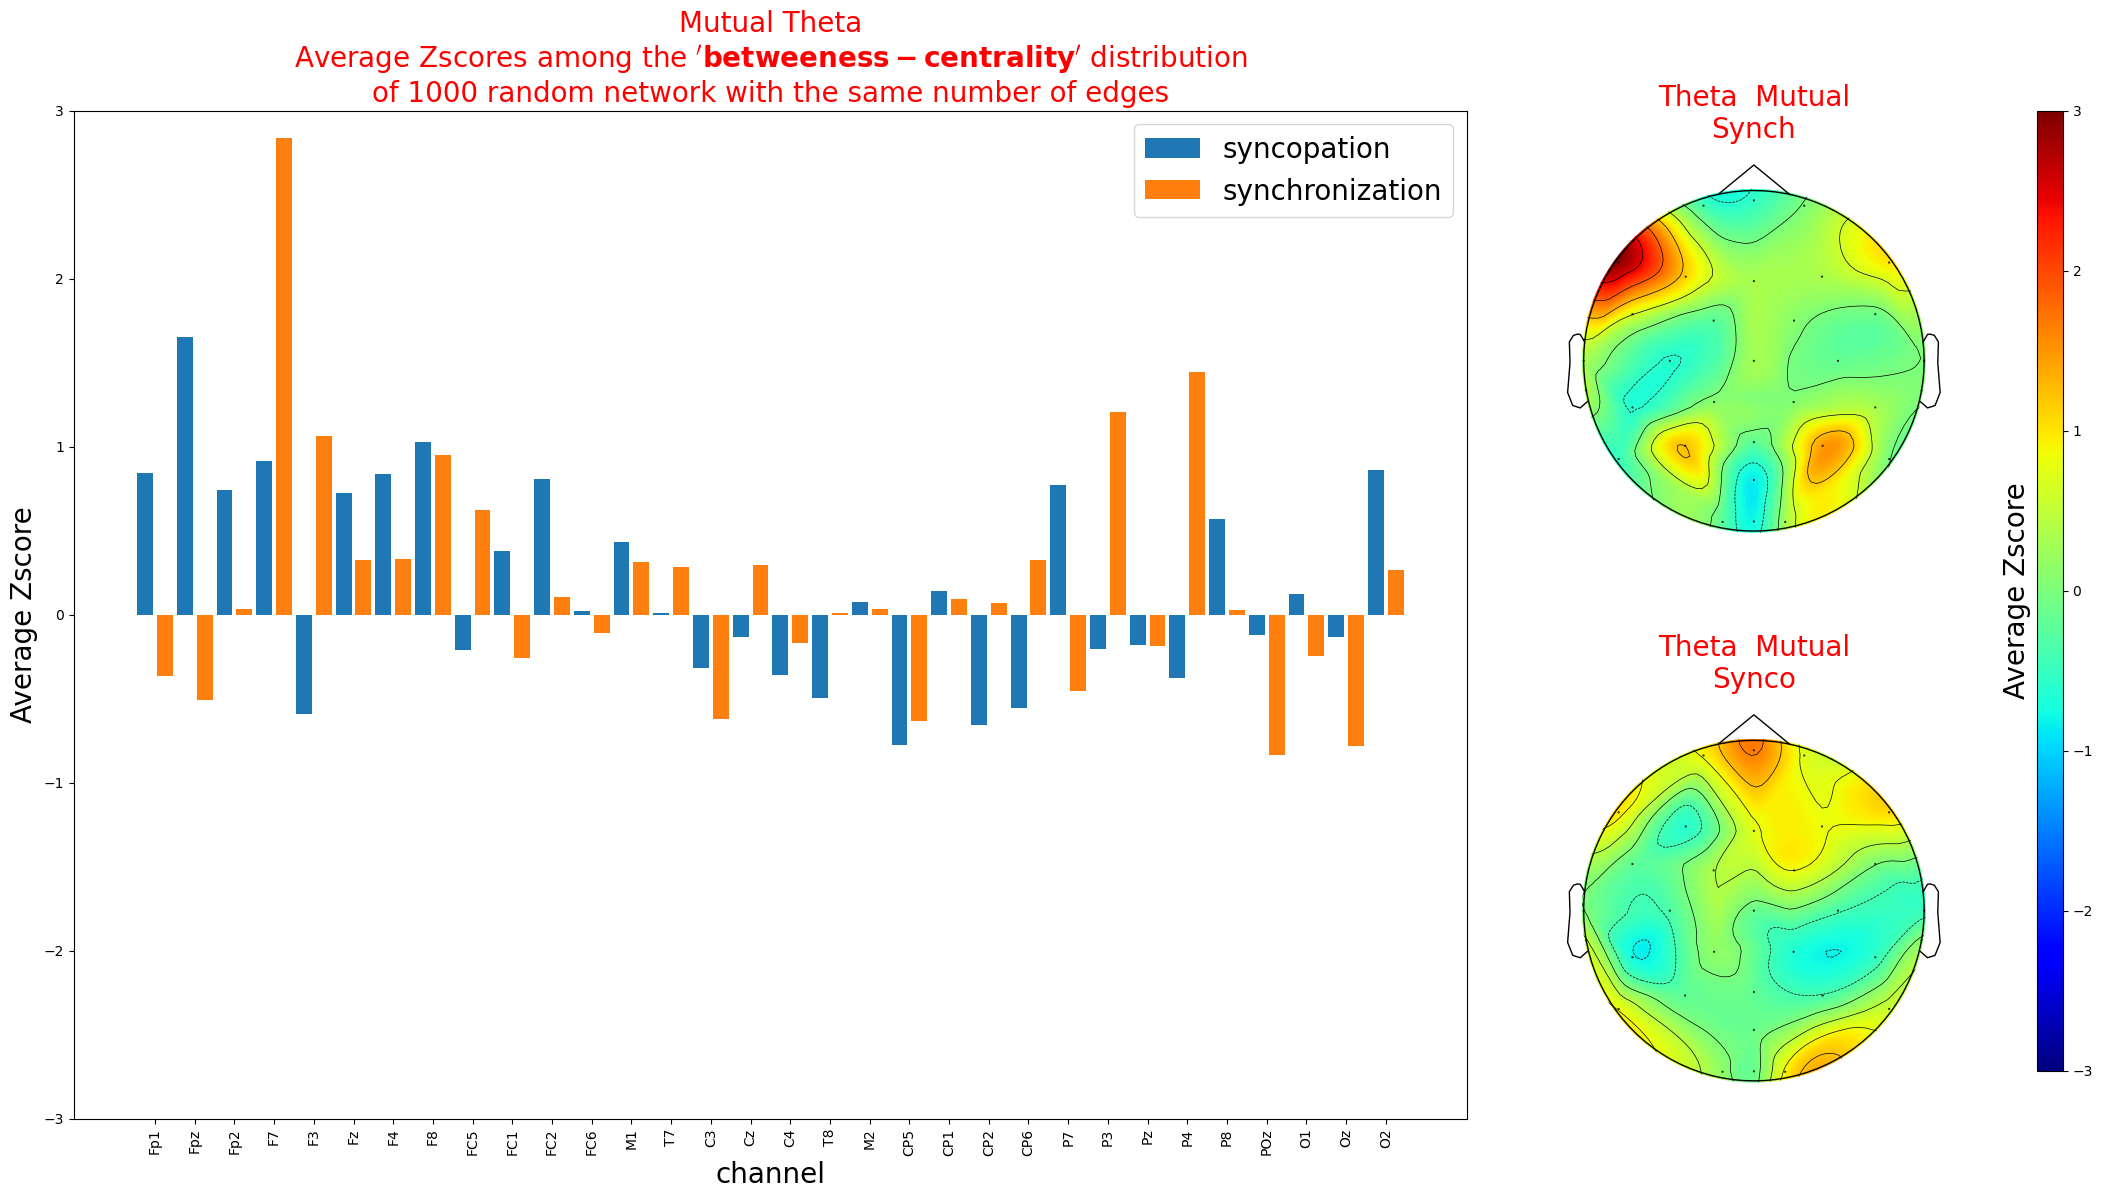

In [26]:
# checking average Zscore
freq=1
lowlim=-3
highlim=3

for st in range(4):
        fig = plt.figure(figsize=(6*4+2, 6*2))
        ax1 = plt.subplot2grid(shape=(2, 4), loc=(0, 0), colspan=3, rowspan=2)
        ax2 = plt.subplot2grid(shape=(2, 4), loc=(0, 3), colspan=1, rowspan=1)
        ax3 = plt.subplot2grid(shape=(2, 4), loc=(1, 3), colspan=1, rowspan=1)

        plt.sca(ax1)
        plt.bar(np.arange(32),zscore_average_syn[1,st,1,:],width = 0.4)
        plt.bar(np.arange(32)+0.5,zscore_average_syn[0,st,1,:],width = 0.4)
        plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
        plt.legend(('syncopation','synchronization'), loc = 'upper right',fontsize=20)
        plt.title(states4names[st] +' ' + band_labels[freq]+'\nAverage Zscores among the '+
                  r"$\bf{'betweeness-centrality'}$"+' distribution'
                        +'\nof 1000 random network with the same number of edges'
                        ,fontsize=20,color=freq7colors[freq])
        plt.xlabel('channel',fontsize = 20)
        plt.ylabel('Average Zscore',fontsize = 20)
        plt.ylim(lowlim,highlim)
                
        for syn in range(2):
                ctr32=zscore_average_syn[syn,st,1,:]
                if syn==0:
                        plt.sca(ax2)
                        im,cm = mne.viz.plot_topomap(ctr32,mne_object.info, vlim=(lowlim,highlim), 
                                                axes=ax2,cmap='jet',show=False)
                        ax2.set_title(band_labels[freq]+'  '+states4names[st]+'\n'+syn2names[syn],
                                color=freq7colors[freq],
                                fontsize=20)
                else:
                        plt.sca(ax3)
                        im,cm = mne.viz.plot_topomap(ctr32,mne_object.info, vlim=(lowlim,highlim), 
                                                axes=ax3,cmap='jet',show=False)
                        ax3.set_title(band_labels[freq]+'  '+states4names[st]+'\n'+syn2names[syn],
                                color=freq7colors[freq],
                                fontsize=20)
                        

        fig.subplots_adjust(right=0.85)
        cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.8])
        cbar_edges=fig.colorbar(im,cbar_ax2)
        cbar_edges.ax.tick_params(labelsize=10)
        cbar_edges.set_label('Average Zscore',fontsize = 20, rotation=90)
        cbar_edges.ax.yaxis.set_label_position('left')

        